## AS8 -- Variational AutoEncoders

Richard Yang

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Create a sampling layer

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 50, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 64, activation="relu")(latent_inputs)  # Change the factor to 50 * 50
x = layers.Reshape((50, 50, 64))(x)  # Adjust the reshape dimensions accordingly
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)  # Adjust the number of channels to 3
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 160000)            480000    
                                                                 
 reshape (Reshape)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 200, 200, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 200, 200, 3)      867 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
# import load_img 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
pic_1 = load_img('C:/Users/Richa/MLcode/Week9/Taylor.png')
pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]
# pic_1 = pic_1[:, -201:-1, 0:200]


pic_1.shape

(1, 200, 200, 3)

In [8]:
# Train the VAE model on the image data
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=30, batch_size=1)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 27726.8281 - reconstruction_loss: 27726.7500 - kl_loss: 0.0777
Epoch 2/30
1/1 [==============================] - 0s 60ms/step - loss: 28216.3926 - reconstruction_loss: 27689.6875 - kl_loss: 526.7052
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 27667.1680 - reconstruction_loss: 27663.3066 - kl_loss: 3.8619
Epoch 4/30
1/1 [==============================] - 0s 56ms/step - loss: 27637.2168 - reconstruction_loss: 27637.2168 - kl_loss: 8.3148e-06
Epoch 5/30
1/1 [==============================] - 0s 52ms/step - loss: 27593.8750 - reconstruction_loss: 27593.8750 - kl_loss: 4.2021e-06
Epoch 6/30
1/1 [==============================] - 0s 57ms/step - loss: 27550.9375 - reconstruction_loss: 27550.9375 - kl_loss: 6.0499e-06
Epoch 7/30
1/1 [==============================] - 0s 58ms/step - loss: 27468.0195 - reconstruction_loss: 27468.0195 - kl_loss: 7.4506e-06
Epoch 8/30
1/1 [==============================

1/1 [==============================] - 0s 111ms/step
z_mean: [[-0.01436142 -0.0054852 ]]
z_log_var: [[-0.000913    0.01059653]]
encoded_imgs: [[1.233228   0.43153316]]
Original Image:
Original Image after cropping:


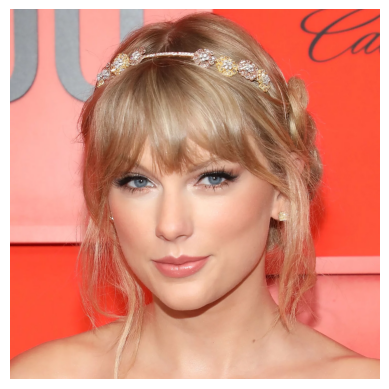

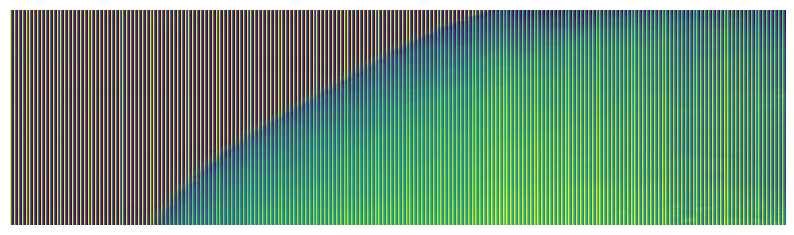

1/1 [==============================] - 0s 113ms/step
decoded Image shape: (1, 200, 200, 3)
decoded Image size: 120000


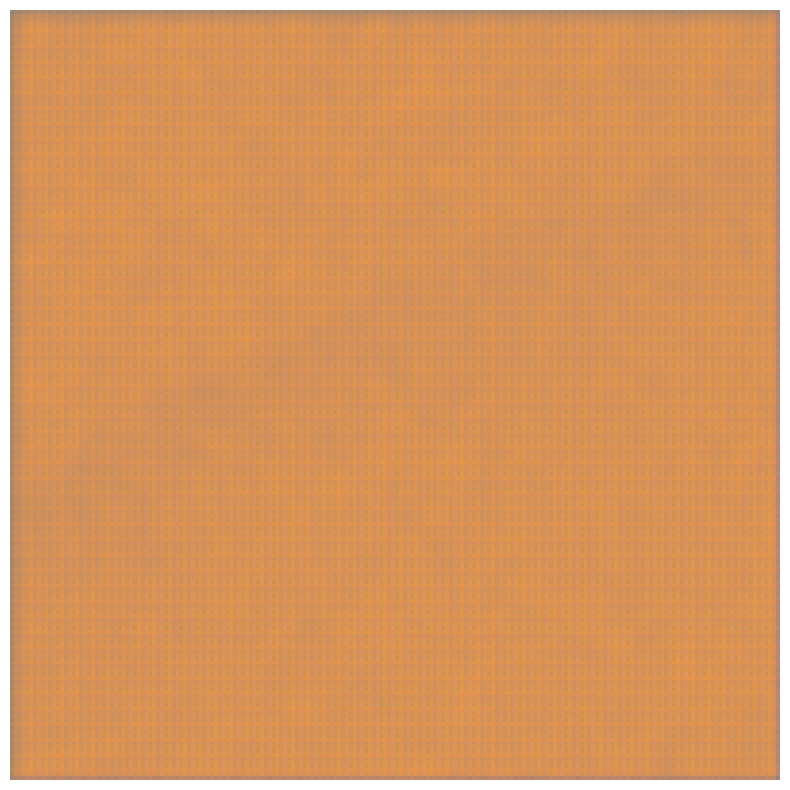

In [9]:
z_mean, z_log_var, encoded_imgs = vae.encoder.predict(pic_1)

print("z_mean:", z_mean)
print("z_log_var:", z_log_var)
print("encoded_imgs:", encoded_imgs)

# Function to display the images
def show_plot(images):
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Display the original image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('Taylor.png')
plt.axis("off")
print("Original Image:")
plt.imshow(img)

# Display the original image after cropping
print("Original Image after cropping:")
show_plot(pic_1[0])

# Generate and display the reconstructed image
decoded_imgs = decoder.predict(encoded_imgs)
print("decoded Image shape:",decoded_imgs.shape)
print("decoded Image size:",decoded_imgs.size)

show_plot(decoded_imgs)


## New Input Data

In [10]:
# import load_img 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
pic_2 = load_img('C:/Users/Richa/MLcode/Week9/biden_image.jpeg')
pic_2 = np.expand_dims(pic_2, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]

pic_2.shape

(1, 200, 200, 3)

1/1 [==============================] - 0s 34ms/step
z_mean: [[-0.01349434 -0.00689978]]
z_log_var: [[-0.00129021  0.01154529]]
encoded_imgs: [[-0.68036264 -0.6659979 ]]
Original Image:
Original Image after cropping:


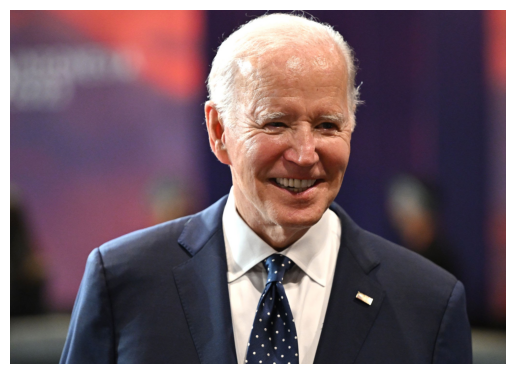

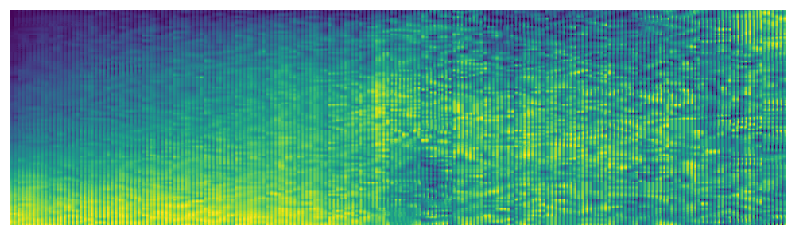

1/1 [==============================] - 0s 42ms/step
decoded Image shape: (1, 200, 200, 3)
decoded Image size: 120000


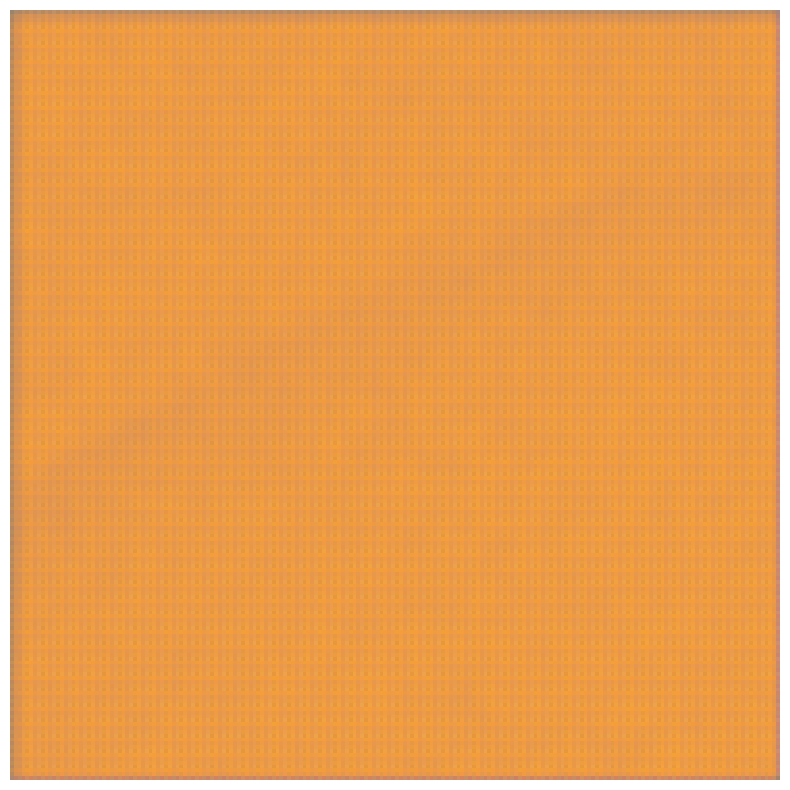

In [12]:
z_mean, z_log_var, encoded_imgs = vae.encoder.predict(pic_2)

print("z_mean:", z_mean)
print("z_log_var:", z_log_var)
print("encoded_imgs:", encoded_imgs)

# Function to display the images
def show_plot(images):
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Display the original image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('biden_image.jpeg')
plt.axis("off")
print("Original Image:")
plt.imshow(img)

# Display the original image after cropping
print("Original Image after cropping:")
show_plot(pic_2[0])

# Generate and display the reconstructed image
decoded_imgs = decoder.predict(encoded_imgs)
print("decoded Image shape:",decoded_imgs.shape)
print("decoded Image size:",decoded_imgs.size)

show_plot(decoded_imgs)


### Explain Why 

We can see that the output for pic_2 is the same as pic_1


Variational Autoencoders (VAEs) are powerful models designed to learn a latent space that captures the underlying distribution of training data. However, training a VAE on a single image limits its ability to generalize and learn meaningful latent representations. This will lead the model to solely focus on reconstructing the individual image rather than capturing the broader spectrum of image variations.

#### How to overcome this limitation
To overcome this limitation and train a VAE effectively, it is essential to have a diverse dataset that captures the wide variations and patterns present in the desired domain. By incorporating a rich and varied collection of images, the VAE can learn a more general latent space representation that can be used to generate new images with similar characteristics to the training data.

By exposing the VAE to diverse examples, such as images with different **lighting conditions**, **various poses**, and **objects of interest**, the model can develop a deeper understanding of the underlying patterns and relationships within the data. This expanded training approach enables the VAE to extract higher-level features and generate outputs that exhibit a wider range of possibilities.

Furthermore, augmenting the dataset with diverse samples allows the VAE to learn more robust and generalizable latent representations. This empowers the model to generate new images that possess similar characteristics to the training data, even when faced with novel inputs. The goal is to train the VAE to learn the underlying distribution of the data, enabling it to generate high-quality and creative outputs.